# Day4 強化学習に対するニューラルネットワークの適用

## NNチュートリアル(多層パーセプトロン)

code4-1  
1層のNNとして  
$$\begin{bmatrix}
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
\end{bmatrix}=
\begin{bmatrix}
    a_{11} & a_{12} \\
    a_{21} & a_{22} \\
    a_{31} & a_{32} \\
    a_{41} & a_{42}
\end{bmatrix}
\begin{bmatrix}
    x_1 \\
    x_2
\end{bmatrix}+
\begin{bmatrix}
    b_1 \\
    b_2 \\
    b_3 \\
    b_4
\end{bmatrix}$$
を考える
* $\mathbf{a}$: 重み, $\mathbf{b}$: バイアス


In [1]:
import numpy as np
from tensorflow.python import keras as K

In [3]:
# 1層のNN定義（入力次元が2)
# seaquentialは複数層をまとめられる、今は全結合層一つのみ
# unit: 出力のサイズ
model = K.Sequential([K.layers.Dense(units=4, input_shape=((2, )))])

weight, bias = model.layers[0].get_weights()
print(f"Weight shape is {weight.shape}")
print(f"Bias shape is {bias.shape}")

# 最初の行がバッチサイズ、次が行
x = np.random.rand(1, 2)
y = model.predict(x)
print(f"x is {x.shape} and y is {y.shape}")

Weight shape is (2, 4)
Bias shape is (4,)
x is (1, 2) and y is (1, 4)


code 4-3 複数データの場合の実装  

活性化関数 sigmoid $f(x) = \frac{1}{1 + e^{-x}}$

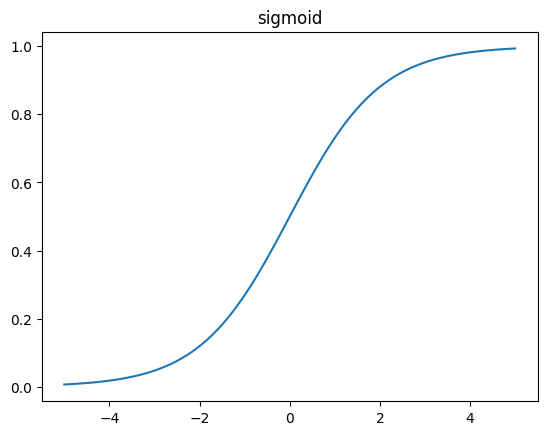

In [4]:
import math
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + math.e**(-x))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x))
plt.title("sigmoid")
plt.show()

複数データはバッチとしてまとめられる (例: バッチサイズ3のデータ)
$$\begin{bmatrix}
    [x^1_1 & x^1_2] \\
    [x^2_1 & x^2_2] \\
    [x^3_1 & x^3_2] \\
\end{bmatrix}
$$

In [5]:
# 2-layer neural network
model = K.Sequential([K.layers.Dense(units=4, input_shape=((2, )), activation="sigmoid"), K.layers.Dense(units=4)])

# Make Batch size 3 data (dimenstion of x is 2)
batch = np.random.rand(3, 2)
y = model.predict(batch)

print(y.shape)

(3, 4)


code4-4 ボストン市の住宅価格の予測  
【メモ】  
softplus = $\log(\exp{\mathbf{x}} + 1)$  
ReLUに似てる関数

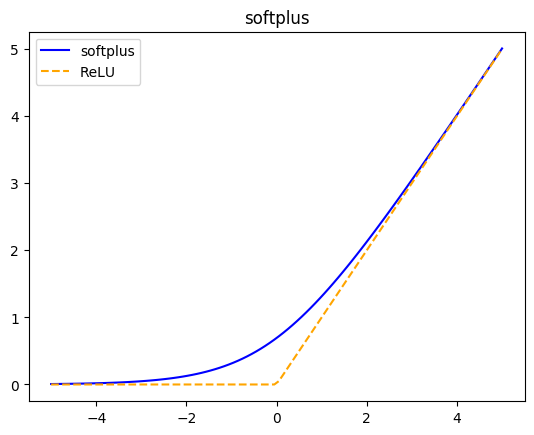

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt

# softplus
x = np.linspace(-5, 5, 100)
y = np.log(np.exp(x) + 1)
relu = x * (x > 0)

plt.plot(x, y, color="blue", label="softplus")
plt.plot(x, relu, color="orange", linestyle="dashed", label="ReLU")
plt.title("softplus")
plt.legend()
plt.show()

NNによるボストンの住宅価格の予測  
* BatchNormalization: バッチサイズごと・各次元で平均、分散を求めて正規化
* regurarize: L1正則化(重みの値を制限, overfitting防止)
* Loss: ２乗誤差
* 最適化手法: sgd

Epoch 1/10
339/339 [==============================] - 0s 307us/sample - loss: 183.5603
Epoch 2/10
339/339 [==============================] - 0s 22us/sample - loss: 41.9250
Epoch 3/10
339/339 [==============================] - 0s 21us/sample - loss: 43.8158
Epoch 4/10
339/339 [==============================] - 0s 21us/sample - loss: 68.2472
Epoch 5/10
339/339 [==============================] - 0s 21us/sample - loss: 22.6626
Epoch 6/10
339/339 [==============================] - 0s 21us/sample - loss: 55.9967
Epoch 7/10
339/339 [==============================] - 0s 21us/sample - loss: 27.7100
Epoch 8/10
339/339 [==============================] - 0s 22us/sample - loss: 28.5452
Epoch 9/10
339/339 [==============================] - 0s 21us/sample - loss: 26.5678
Epoch 10/10
339/339 [==============================] - 0s 21us/sample - loss: 32.4150


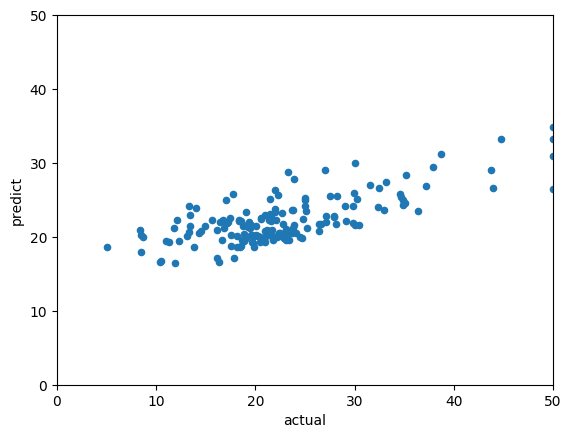

In [7]:

dataset = load_boston()

y = dataset.target
x = dataset.data

# About train : test = 7 : 3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

model = K.Sequential([
    K.layers.BatchNormalization(input_shape=(13, )), # 13の特徴量の値全てを[0, 1]に
    K.layers.Dense(units=13, activation="softplus", kernel_regularizer="l1"), # softplus, l1正則化
    K.layers.Dense(units=1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")
model.fit(X_train, y_train, epochs=10)

predicts = model.predict(X_test)
result = pd.DataFrame({
    "predict": np.reshape(predicts, (-1, )),
    "actual": y_test
})
limit = np.max(y_test)
result.plot.scatter(x="actual", y="predict", xlim=(0, limit), ylim=(0, limit))
plt.show()

## NNチュートリアル(CNN)

code 4-5
CNNの構造
* 入力: N×8×8×1の画像とする

|層の名前|カーネルサイズ|ストライド|パディング|出力の次元(NHWC)|
|:--:|:--:|:--:|:--:|:--:|
|畳込み + ReLU|3×3|1|入力と同じになるように|N×8×8×5|
|畳込み + ReLU|2×2|1|"|N×8×8×3|
|flatten層(画像になっていたものを1次元のベクトル化||||N×192|
|全結合層||||N×10|

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from tensorflow.python import keras as K


dataset = load_digits()
image_shape = (8, 8, 1)
num_class = 10

y = dataset.target
y = K.utils.to_categorical(y, num_class)
X = dataset.data
X = np.array([data.reshape(image_shape) for data in X])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = K.Sequential([
    K.layers.Conv2D(
        5, kernel_size=3, strides=1, padding="same",
        input_shape=image_shape, activation="relu"),
    K.layers.Conv2D(
        3, kernel_size=2, strides=1, padding="same",
        activation="relu"),
    K.layers.Flatten(),
    K.layers.Dense(units=num_class, activation="softmax")
])
# 最適化やロスの設定
model.compile(loss="categorical_crossentropy", optimizer="sgd")
# 実際の学習
model.fit(X_train, y_train, epochs=8)

predicts = model.predict(X_test)
predicts = np.argmax(predicts, axis=1)
actual = np.argmax(y_test, axis=1)
print(classification_report(actual, predicts))

Epoch 1/8
1203/1203 [==============================] - 0s 116us/sample - loss: 2.2443
Epoch 2/8
1203/1203 [==============================] - 0s 51us/sample - loss: 1.3413
Epoch 3/8
1203/1203 [==============================] - 0s 50us/sample - loss: 0.7139
Epoch 4/8
1203/1203 [==============================] - 0s 51us/sample - loss: 0.4749
Epoch 5/8
1203/1203 [==============================] - 0s 51us/sample - loss: 0.3474
Epoch 6/8
1203/1203 [==============================] - 0s 49us/sample - loss: 0.2781
Epoch 7/8
1203/1203 [==============================] - 0s 51us/sample - loss: 0.2362
Epoch 8/8
1203/1203 [==============================] - 0s 51us/sample - loss: 0.1991
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        59
           1       0.96      0.78      0.86        65
           2       0.98      0.95      0.96        58
           3       0.95      0.89      0.92        61
           4       0.98      0.97      0.98     

0 ~ 9のクラスそれぞれに対するprecision, recall, f1及び全体に対するacc  
0と4と6はほぼ間違えない、一方で8は間違えやすい

データの表示(間違えたのをあえてプロット)
実際は8だが下の丸が潰れていて予測は2になっている

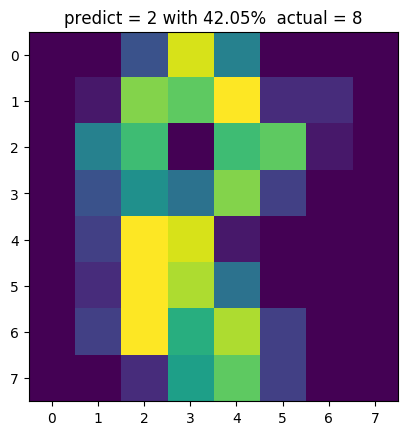

In [16]:
i = 7
predict_label = np.argmax(model.predict(X_test[i].reshape(-1, 8, 8, 1)))
predict_proba = np.max(model.predict(X_test[i].reshape(-1, 8, 8, 1)))
actual = np.argmax(y_test[i])

plt.title(f"predict = {predict_label} with {predict_proba * 100:.4}%  actual = {actual}")
plt.imshow(X_test[i, :, :, 0])
plt.show()